# **Example of use of SITS Package - The basics**

---

We aim to follow the **geomorphological evolution** of the **Banc d'Arguin**.

> _"The Banc d'Arguin is a sandbank about 4 km long and 2 km wide at low tide. The bank is more or less visible depending on the state of the tide. In addition, under the action of sea currents, tides and wind, it continually changes shape and location. It is located opposite the entrance to the Arcachon basin, between the Dune du Pilat and the tip of Cap Ferret"_ (source: [wikipedia](https://fr.wikipedia.org/wiki/R%C3%A9serve_naturelle_nationale_du_Banc-d%27Arguin)).

<p align="center"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/4e/Parc_naturel_marin_du_bassin_d%27Arcachon_vu_du_ciel_-_Banc_d%27Arguin_%281%29.JPG/1280px-Parc_naturel_marin_du_bassin_d%27Arcachon_vu_du_ciel_-_Banc_d%27Arguin_%281%29.JPG" alt="Banc d'Arguin" width="600"></p>
<p align="center"><sup>Arcachon Basin Marine Natural Park seen from the sky, from a light aircraft Tecnam P2002 (&copy; Dorian Bentejac)</sup></p>
We have a vector file that gives the position of this sandy shape. We will use it to retrieve a time series of satellite images, i.e. Sentinel-2, made available through a STAC catalog (i.e. Microsoft Planetary).
Then we will apply a cloud mask on each frame and replace the nodata values by temporal interpolation (i.e. gap-filling).
Finally we will export the results in the form of animated gif.

---

### 1. Installation of SITS package and its depedencies

First, install `sits` package with [pip](https://pypi.org/project/SITS/). We also need some other packages for displaying data.

In [ ]:
# SITS package
!pip install -q --upgrade sits

# other packages
!pip install -q folium
!pip install -q mapclassify
!pip install -q matplotlib

Now we can import `sits` and some other libraries.

In [2]:
import os
# sits lib
from sits import sits
# geospatial libs
import geopandas as gpd
import pandas as pd
# date format
from datetime import datetime
# ignore warnings messages
import warnings
warnings.filterwarnings('ignore') 

## 2. Handling the input vector file

### 2.1. Data loading

The geojson vector file describing the position of the sandbank is stored in the [Github repository](https://github.com/kenoz/SITS_utils). We download it into our current workspace.  

In [ ]:
!mkdir -p test_data
![ ! -f test_data/banc_arguin.geojson ] && wget https://raw.githubusercontent.com/kenoz/SITS_utils/refs/heads/main/data/banc_arguin.geojson -P test_data

We load the vector file, named `banc_arguin.geojson`, as a geoDataFrame object with the `sits` method: `sits.Vec2gdf()`.

In [4]:
data_dir = 'test_data'
v_arguin = sits.Vec2gdf(os.path.join(data_dir, 'banc_arguin.geojson'))
v_arguin.gdf

,id,id_poly,geometry
0,1,1,"MULTIPOLYGON (((-1.27422 44.63147, -1.19528 44..."


### 2.1. Bounding box calculation

We check the coordinate reference system (CRS) and calculate the bounding box with the method `set_bbox()` of class `sits.Vec2gdf`.

In [5]:
# check epsg
print(f"epsg code for 'v_arguin.gdf':  {v_arguin.gdf.crs.to_epsg()}")

# calculates the bounding box for each feature.
v_arguin.set_bbox('gdf')
print(f"epsg code for 'v_arguin.bbox': {v_arguin.bbox.crs.to_epsg()}")

epsg code for 'v_arguin.gdf':  4326
epsg code for 'v_arguin.bbox': 4326


We display the `sits.Vec2gdf` objects (`.gdf` and _in green_ `.bbox` _in blue_) on an interactive map.

In [6]:
import folium

f = folium.Figure(height=300)
m = folium.Map(location=[44.6, -1.2], zoom_start=11).add_to(f)
v_arguin.gdf.explore(m=m, height=400, color='green')
v_arguin.bbox.explore(m=m, height=400)

### 2.3. CRS management

In order to request data on a STAC catalog, we need to provide the bounding box coordinates in Lat/Long, i.e the EPSG:4326. Then we also need to specify in which CRS we want to obtain the satellite time series. As we are working in France, it can be the EPSG 2154 (RGF-93, Lambert-93) or the EPSG 3035 (ETRS89-extended), valid at the European scale.

Here we calculate the coordinates in EPSG:4326 and EPSG:3035. Since there is only one polygon, we keep the coordinates into two lists.

In [7]:
bbox_4326 = list(v_arguin.bbox.iloc[0]['geometry'].bounds)
bbox_3035 = list(v_arguin.bbox.to_crs(3035).iloc[0]['geometry'].bounds)

print(f'bbox in EPSG:4326: {bbox_4326}')
print(f'bbox in EPSG:3035: {bbox_3035}')

bbox in EPSG:4326: [-1.283356958716803, 44.54723753300113, -1.195282436226136, 44.63147049370678]
bbox in EPSG:3035: [3426472.0201418595, 2448438.7064564982, 3434719.22278734, 2458751.114093349]


## 3. Loading and preprocessing of a Satellite Image Time-Series (SITS)

In this example, we have only one area (one polygon) to process. We use the class `sits.StacAttack` to request and preprocess the data. In case you need to distribute the processing, take a look on the `sits.Multiproc()` approach, using `Dask`.

### 3.1. Creation of a Datacube from STAC catalog

The request consists in retrieving Sentinel-2 images (level 2A) acquired from January 1, 2016 to January 1, 2025 with cloud cover less than 10%. Then we build a 4 bands geo-datacube ('B03', 'B04', 'B08' and 'SCL') in EPSG:3035 with a 20m spatial resolution.

In [8]:
# instance of the class sits.StacAttack()
ts_S2 = sits.StacAttack(provider='mpc',
                        collection='sentinel-2-l2a',
                        bands=['B03', 'B04', 'B08', 'SCL'])

# search of items based on bbox coordinates and time interval criteria
ts_S2.searchItems(bbox_4326,
                  date_start=datetime(2016, 1, 1),
                  date_end=datetime(2025, 1, 1),
                  query={"eo:cloud_cover": {"lt": 10}}
                 )
# load of the time series in a lazy way
ts_S2.loadCube(bbox_3035, resolution=20, crs_out=3035)

The method `StacAttack.loadCube()` returns an object `StacAttack.cube` i.e. an `xarray.Dataset()`. If necessary, you can modify it using the methods of `xarray.Dataset()` (not really recommended).

In [9]:
type(ts_S2.cube)

xarray.core.dataset.Dataset

### 3.2. Create and apply a mask

We want to mask the defective and cloudy pixels in the Datacube (`StacAttack.cube`). To do this, we use the SCL band provided with the Sentinel-2 images. SCL refers to "Scene Classification Layer" and has been developed to developed to distinguish between cloudy pixels, clear pixels and water pixels. It consists of 12 classes.

In this example we create a mask based on the following classes:
- 0: No Data (Missing data)
- 1: Saturated or defective pixel
- 3: Cloud shadows
- 8: Cloud medium probability
- 9: Cloud high probability
- 10: Thin cirrus



In [10]:
# classes used to mask
SCL_mask = [0, 1, 3, 8, 9, 10]
# creation of the SCL mask
ts_S2.mask(mask_band='SCL', mask_values=[SCL_mask])

The method `StacAttack.mask()` returns an object `StacAttack.mask` i.e. an `xarray.Dataaarray()`.

In [11]:
ts_S2.mask

<xarray.DataArray 'SCL' (time: 108, y: 259, x: 207)> Size: 6MB
dask.array<any-aggregate, shape=(108, 259, 207), dtype=bool, chunksize=(1, 259, 207), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 2.459e+06 2.459e+06 ... 2.448e+06 2.448e+06
  * x            (x) float64 2kB 3.426e+06 3.426e+06 ... 3.435e+06 3.435e+06
    spatial_ref  int32 4B 3035
  * time         (time) datetime64[ns] 864B 2016-03-18T11:11:02.030000 ... 20...

We can apply the mask on the Satellite Image Time Series with the method `StacAttack.mask()`.

In [12]:
ts_S2.mask_apply()

### 3.3. Gap filling the masked pixels

We interpolate in time the masked pixels (NaN values). The method `StacAttack.gapfill()` relies on the `xarray.DataArray.interpolate_na`. By default the linear interpolation is used but you can try another one (see the related [documentation](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interpolate_na.html)). As the interpolation needs backward and forward values, the first and the last images are not processed. To avoid this, the method `StacAttack.gapfill()` also call the methods `xarray.DataArray.bfill` and `xarray.DataArray.ffill`. You can disable this by passing the argument `first_last=False`.

In [13]:
%%time

ts_S2.gapfill()

CPU times: user 71.1 ms, sys: 7.69 ms, total: 78.8 ms
Wall time: 75 ms


## 4. Saving the Datacube as a file

### 4.1. Default export

It is possible to export the Datacube in NetCDF (Network Common Data Form) or in CSV (Comma-Separated Values).


In [14]:
%%time

# export to NETcdf
ts_S2.to_nc(data_dir)

#export to csv
#ts_S2.to_csv(data_dir)

CPU times: user 46.6 s, sys: 24.3 s, total: 1min 10s
Wall time: 25.5 s


The output filename is automaticaly made with the following syntax:
```sh
fid-<gid>_<array type>_<start date>-<end date>.nc
```


In [15]:
%%time

netcdf = [i for i in os.listdir(data_dir) if i.endswith('.nc')]
netcdf

CPU times: user 2.41 ms, sys: 282 µs, total: 2.69 ms
Wall time: 1.73 ms


['S2_fid-None_image_2016-01-01 00:00:00-2025-01-01 00:00:00.nc']

## 5. Convert NetCDF file into animated GIF

Last but not least... sits package allows you to export satellite time series as animated GIF, so you can easily show some phenoma that vary in time and space.

### 5.1. Loading NetCDF file

We load the newly created NetCDF file as an `xarray.Dataarray`, and choose to keep only three spectral bands in order to display color composites (RGB format).

In [16]:
%%time

netcdf_path = os.path.join(data_dir, netcdf[0])

test = sits.export.Sits_ds(netcdf_path)
test.ds2da(keep_bands=['B08', 'B04', 'B03'])

CPU times: user 106 ms, sys: 162 ms, total: 268 ms
Wall time: 807 ms


### 5.2. Making a nice-looking animation

To convert the `xarray.Dataarray` object into an animated GIF, `sits` package uses in the geogif library. So it is possible to add specific arguments, not presented by default.

In [17]:
%%time

out_gif= os.path.join(data_dir, 'banc_arguin.gif')
test.export2gif(imgfile=out_gif)

CPU times: user 1.3 s, sys: 595 ms, total: 1.89 s
Wall time: 1.95 s


Now it's time to see the result. Enjoy the movie!

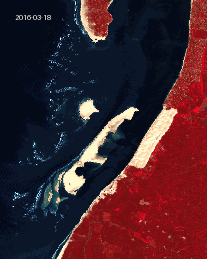

CPU times: user 43.4 ms, sys: 12.1 ms, total: 55.6 ms
Wall time: 57.2 ms


In [18]:
%%time

from IPython.display import Image, display
display(Image(filename=out_gif))

<p align="center">
<img src="img/banc_arguin.gif" alt="banc_arguin.gif">
</p>